# Spread

Ce notebook a servi à mettre au point le modèle de diffusion du poluant qu'on utilise ici, à savoir un simple noyau de convolution appliqué à chaque pas de tems.

C'est un modèle simpl(ist)e, mais on dira qu'il fera le job pour le moment !

La difficulté sera de le régler correctement (par l'intermédiaire du paramètre `spread_speed_sigma_mph` dans le script de simulation (cf `suntox.py` et `suntox__fate_modelling.ipynb`). J'ai pas réussi à trop trouver d'info sur ça - mais je suis pas très fort en biblio et j'y ai pas non plus passé des heures. Cet article peut-être : https://environmentalsystemsresearch.springeropen.com/articles/10.1186/s40068-016-0070-5

In [20]:
# To make sure that you run an up-to-date version of your package:
# always do "Kernel > Restart and Run All"
LOG="/tmp/log_install"
!(cd ..; pip install . > $LOG 2>&1 || (echo "ERROR: INSTALL FAILED ! "; cat $LOG); cd - > /dev/null;)
from suntox import spread as ss

In [21]:
import numpy as np
from matplotlib import pyplot as plt
from datetime import timedelta, datetime
from tqdm import tqdm

In [22]:
roi = dict(np.load("../data/roi.npz"))

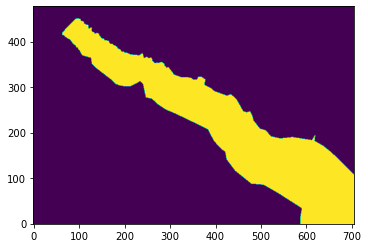

In [23]:
plt.imshow(roi["sea"].T, origin="lower")

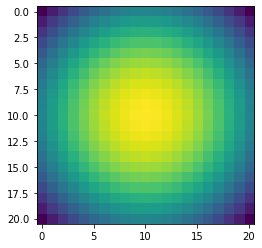

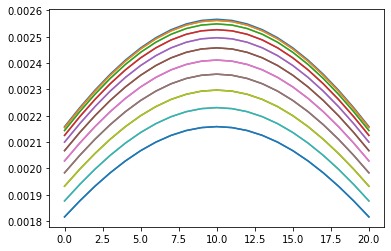

In [24]:
kernel = ss.gauss2D(shape=(21,21), sigma=17)
plt.imshow(kernel)
plt.show()
plt.plot(kernel)
plt.show()

In [25]:
scaled_mask = ss.scaled_mask(roi["sea"], kernel)

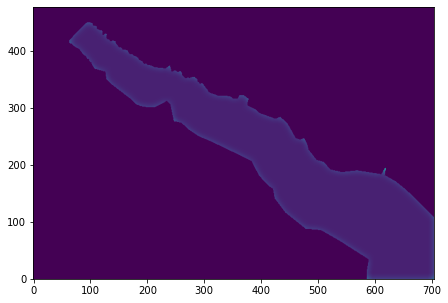

In [26]:
plt.figure(figsize=(10,5))
plt.imshow(scaled_mask.T, origin="lower")
plt.show()

In [ ]:
spread = np.zeros(scaled_mask.shape)
spread[100, 400] = 1
days = 122
step_dly = 30
steps = int(60 * 12 / step_dly)
log_granularity_min = 30
sums = []

for i in tqdm(range(int(24*60/step_dly/steps*days))):
    dat = {}
    t0 = datetime.now()
    for j in range(steps):
        sums.append(spread.sum())
        spread = ss.spread_iteration(spread, kernel, scaled_mask)
        if j % log_granularity_min == 0:
            dat[f"{timedelta(minutes = step_dly*(1+j))}"] = spread
    # np.savez_compressed(f"/tmp/period_{i:03d}", **dat)
    dly = (datetime.now() - t0)
    plt.imshow(np.log(1+spread.T), origin="lower")
    plt.title(f"t0 + {timedelta(minutes=step_dly*steps*(1+i))}, "
              + f"compute {dly.total_seconds():.1f} s, "
              + f"sum {spread.sum():.2f}")
    plt.show()